In [1]:
import sys
sys.path.insert(0, "../")

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from mlxtend.plotting import plot_decision_regions

from data import BertTweetPreprocessor
from data.preprocess import tag_indicators, replace_xml_and_html
from data import parse_dataset
from base import load_hyperparameters
from experiments.experiment import AbstractSklearnExperiment
from experiments.statistical import get_ner_wrapper, get_sentiment_wrapper
import statistical.data_extraction as ex

In [3]:
x, y = parse_dataset("../../datasets", "en")
preprocessor = BertTweetPreprocessor([tag_indicators, replace_xml_and_html])
x = preprocessor.transform(x)
kfold = StratifiedKFold(n_splits=10)
splits = list(kfold.split(x, y))


def load_model(path_to_hyperparameters, model_type):
    hp = load_hyperparameters(path_to_hyperparameters)
    model = AbstractSklearnExperiment.build_model(AbstractSklearnExperiment, hp)

    if model_type == "readability":
        extractor = ex.readability_tweet_extractor()
    elif model_type == "ner":
        extractor = ex.ner_tweet_extractor(get_ner_wrapper(hp))
    elif model_type == "sentiment":
        extractor = ex.sentiment_tweet_extractor(get_sentiment_wrapper(hp))
    else:
        raise ValueError("Invalid value for `model_type`")

    return extractor, model


def fit_model(path_to_hyperparameters, model_type):
    extractor, model = load_model(path_to_hyperparameters, model_type)
    xt = extractor.transform(x)

    predictions = []
    for x_train_indices, x_test_indices in splits:
        x_train = xt[x_train_indices]
        y_train = y[x_train_indices]
        x_test = xt[x_test_indices]
        y_test = y[x_test_indices]

        model.fit(x_train, y_train)
        pred = model.predict_proba(x_test)
        predictions.append([pred, y_test])

    return np.asarray(predictions)

In [45]:
def plot_roc(predictions):
    rates = np.asarray([roc_curve(y_true, pred[:, -1].reshape(-1))[:2] for pred, y_true in predictions])
    length = max([len(fpr) for fpr, _ in rates])
    rates = np.asarray([
        [np.pad(fpr, (0, length-len(fpr)), constant_values=1.), np.pad(tpr, (0, length-len(tpr)), constant_values=1.)]
        for fpr, tpr in rates
    ])
    rates_mean = np.mean(rates, axis=0)
    rates_mean_plus_std = rates_mean[1] + np.std(rates[1], axis=0)
    rates_mean_minus_std = rates_mean[1] - np.std(rates[1], axis=0)

    print("AUC:", auc(rates_mean[0], rates_mean[1]))
    plt.plot(rates_mean[0], rates_mean[1])
    plt.plot(rates_mean[0], rates_mean_plus_std, color="blue", alpha=0.2)
    plt.plot(rates_mean[0], rates_mean_minus_std, color="blue", alpha=0.2)
    plt.fill_between(rates_mean[0], rates_mean_minus_std, rates_mean_plus_std, alpha=0.2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")


def plot_model_decision_regions(path_to_hyperparameters, model_type):
    extractor, model = load_model(path_to_hyperparameters, model_type)
    xt = extractor.transform(x)

    model.fit(xt, y)
    plot_decision_regions(xt, y.astype(np.int32), clf=model, legend=2)
    plt.title("Decision Regions")

def plot_confusion_matrix(predictions):
    matrices = []
    for pred, y_trues in predictions:
        confusion_matrix = np.full((2, 2), 0)
        y_preds = np.argmax(pred, axis=1)

        for y_pred, y_true in zip(y_preds, y_trues):
            if y_pred == 1 and y_true == 1:  # True positive
                confusion_matrix[0, 0] += 1
            elif y_pred == 1 and y_true == 0:  # False positive
                confusion_matrix[0, 1] += 1
            elif y_pred == 0 and y_true == 0:  # True negative
                confusion_matrix[1, 1] += 1
            elif y_pred == 0 and y_true == 1:  # False negative
                confusion_matrix[1, 0] += 1

        matrices.append(confusion_matrix)

    confusion_matrix = np.mean(matrices, axis=0)
    sn.heatmap(confusion_matrix, annot=True, xticklabels=[1, 0], yticklabels=[1, 0])


def calculate_density(x, x_range=None):
    if x_range is None:
        x_range = np.linspace(min(x), max(x), 200)

    density = gaussian_kde(x)
    density.covariance_factor = lambda: .15
    density._compute_covariance()
    return x_range, density(x_range)


def density_plot(x, axes=None, xlabel=None, ylabel=None, title=None, labels=None):
    if axes is None:
        axes = plt

    if isinstance(x, list) or isinstance(x, tuple):
        x_truth_values, x_fake_values = x
    else:
        x_truth_values = x[y == 0]
        x_fake_values = x[y == 1]

    x_range = np.linspace(min(min(x_truth_values), min(x_fake_values)), 
                          max(max(x_truth_values), max(x_fake_values)), 200)
    
    # Plot truthful users
    x_truth, y_truth = calculate_density(x_truth_values, x_range=x_range)
    axes.plot(x_truth, y_truth, alpha=0.8, label=None if labels is None else labels[0])
    axes.fill_between(x_truth, y_truth, alpha=0.6)
    
    # Plot fake users
    x_fake, y_fake = calculate_density(x_fake_values, x_range=x_range)
    axes.plot(x_fake, y_fake, alpha=0.8, label=None if labels is None else labels[1])
    axes.fill_between(x_fake, y_fake, alpha=0.6)
    
    if xlabel is not None:
        if axes is None:
            axes.xlabel(xlabel)
        else:
            axes.set_xlabel(xlabel)
    if ylabel is not None:
        if axes is None:
            axes.ylabel(ylabel)
        else:
            axes.set_ylabel(ylabel)
    if title is not None:
        if axes is None:
            axes.title(title)
        else:
            axes.set_title(title)


def correlation_matrix(data, data_labels=None):
    data_correlation = pd.DataFrame(data, columns=data_labels).corr()

    fig, ax = plt.subplots(figsize=(22, 12))
    sn.heatmap(data_correlation, linewidths=0.1, annot=True, ax=ax)
    plt.show()

# Readability model

## Feature plots

In [6]:
import statistical.data_extraction.readability as read

#### Tag counts

In [503]:
extractor = ex.TweetStatsExtractor([read.tag_counts])
x_tag_counts = extractor.transform(x)

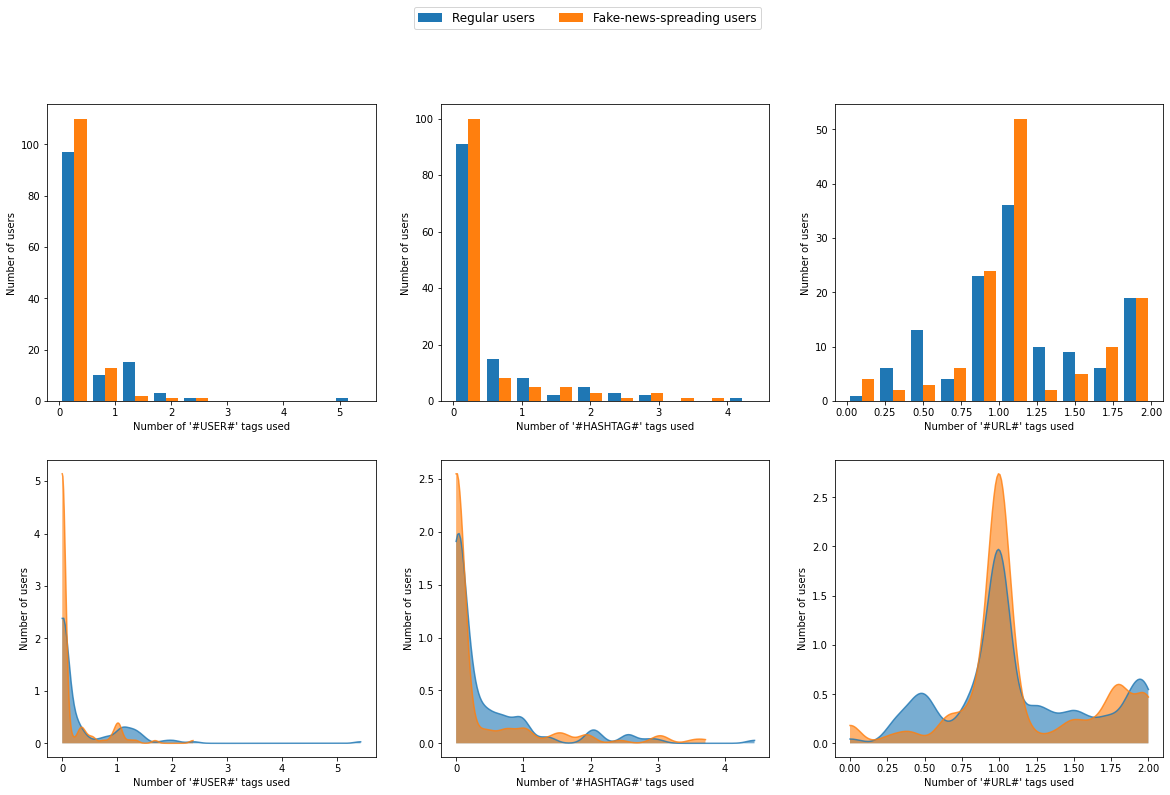

In [505]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 12))

tags = ["#USER#", "#HASHTAG#", "#URL#"]
for i in range(x_tag_counts.shape[-1]):
    ax[0][i].hist([x_tag_counts[y == 0, i], x_tag_counts[y == 1, i]], label=["Regular users", "Fake-news-spreading users"])
    ax[0][i].set_ylabel("Number of users")
    ax[0][i].set_xlabel(f"Number of '{tags[i]}' tags used")
    
    density_plot(x_tag_counts[:, i], 
                 axes=ax[1][i],
                 xlabel=f"Number of '{tags[i]}' tags used",
                 ylabel="Number of users",
                 labels=["Regular users", "Fake-news-spreading users"])

fig.legend(*ax[0][0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=12)

In [534]:
# i = 2
# fig = plt.figure(figsize=(8, 6), dpi=300)
# density_plot(x_tag_counts[:, i], 
#              labels=["Regular users", "Fake-news-spreading users"])
# plt.ylabel("Density", fontsize=12)
# plt.xlabel(f"Number of '{tags[i]}' tags used", fontsize=12)
# plt.legend(fontsize=12)

#### Emoji counts

In [507]:
extractor = ex.TweetStatsExtractor([lambda tweet_feed: read.emojis_counts(tweet_feed)[0]])
x_emoji_counts = extractor.transform(x).flatten()

In [508]:
127 - len(x_emoji_counts[y == 0][x_emoji_counts[y == 0] == 0]), 127 - len(x_emoji_counts[y == 1][x_emoji_counts[y == 1] == 0])

(57, 32)

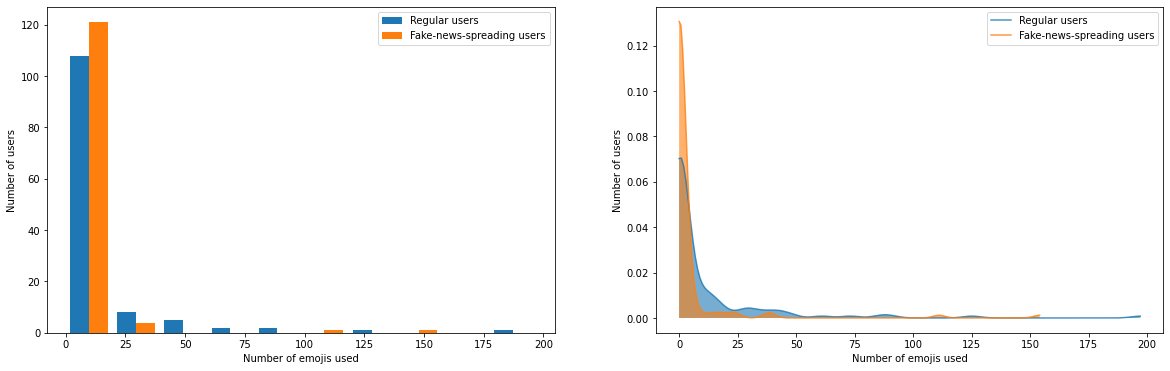

In [509]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 6))

ax[0].hist([x_emoji_counts[y == 0], x_emoji_counts[y == 1]], label=["Regular users", "Fake-news-spreading users"])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Number of emojis used")

density_plot(x_emoji_counts, 
             axes=ax[1],
             xlabel="Number of emojis used",
             ylabel="Number of users",
             labels=["Regular users", "Fake-news-spreading users"])

ax[0].legend()
ax[1].legend()

#### Tweet lengths

In [510]:
extractor = ex.TweetStatsExtractor([read.average_tweet_lengths])
x_tweet_lens = extractor.transform(x)

In [511]:
lens = [len(tweet) for tweet_feed in x for tweet in tweet_feed]
print((min(lens), max(lens), np.mean(lens)))

(0, 152, 87.66448818897638)


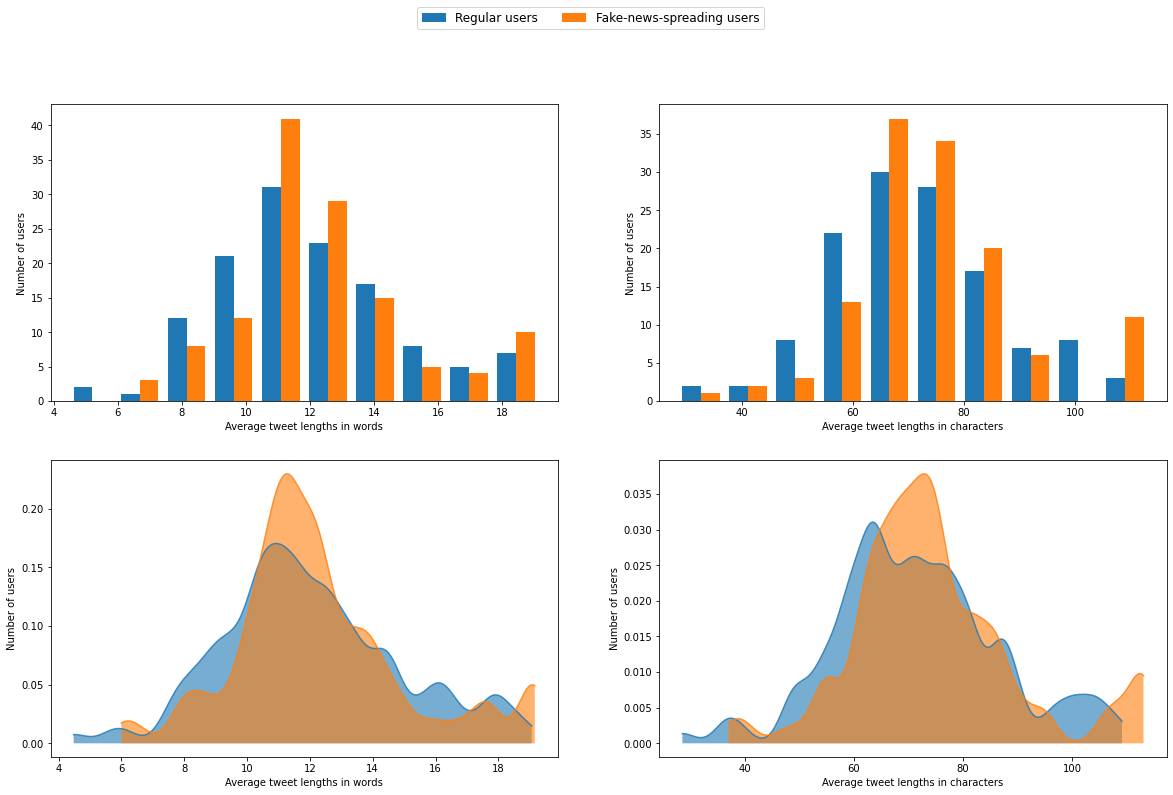

In [512]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 12))

counter = ["words", "characters"]
for i in range(x_tweet_lens.shape[-1]):
    ax[0][i].hist([x_tweet_lens[y == 0, i], x_tweet_lens[y == 1, i]], label=["Regular users", "Fake-news-spreading users"])
    ax[0][i].set_ylabel("Number of users")
    ax[0][i].set_xlabel(f"Average tweet lengths in {counter[i]}")
    
    density_plot(x_tweet_lens[:, i], 
                 axes=ax[1][i],
                 xlabel=f"Average tweet lengths in {counter[i]}",
                 ylabel="Number of users",
                 labels=["Regular users", "Fake-news-spreading users"])

fig.legend(*ax[0, 0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=12)

In [537]:
# i = 1
# fig = plt.figure(figsize=(8, 6), dpi=300)
# density_plot(x_tweet_lens[:, i], 
#              labels=["Regular users", "Fake-news-spreading users"])
# plt.ylabel("Density", fontsize=12)
# plt.xlabel(f"Average tweet lengths in {counter[i]}", fontsize=12)
# plt.legend(fontsize=12)

#### Truncated tweets

In [514]:
extractor = ex.TweetStatsExtractor([read.truncated_tweets])
x_ellipses = extractor.transform(x).flatten()

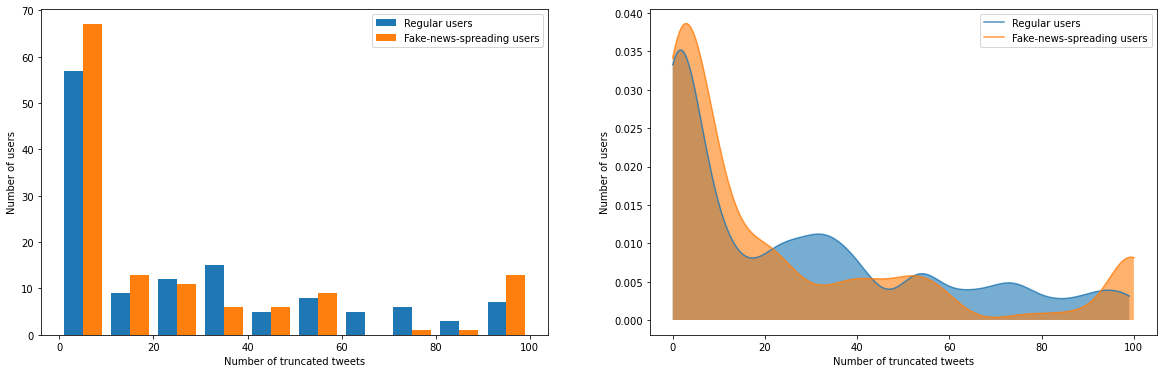

In [515]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 6))

ax[0].hist([x_ellipses[y == 0], x_ellipses[y == 1]], label=["Regular users", "Fake-news-spreading users"])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Number of truncated tweets")

density_plot(x_ellipses, 
             axes=ax[1],
             xlabel="Number of truncated tweets",
             ylabel="Number of users",
             labels=["Regular users", "Fake-news-spreading users"])

ax[0].legend()
ax[1].legend()

In [539]:
# fig = plt.figure(figsize=(8, 6), dpi=300)
# density_plot(x_ellipses, 
#              labels=["Regular users", "Fake-news-spreading users"])
# plt.ylabel("Density", fontsize=12)
# plt.xlabel("Number of truncated tweets", fontsize=12)
# plt.legend(fontsize=12)

#### Number counts

In [517]:
extractor = ex.TweetStatsExtractor([read.number_counts])
x_numbers = extractor.transform(x)

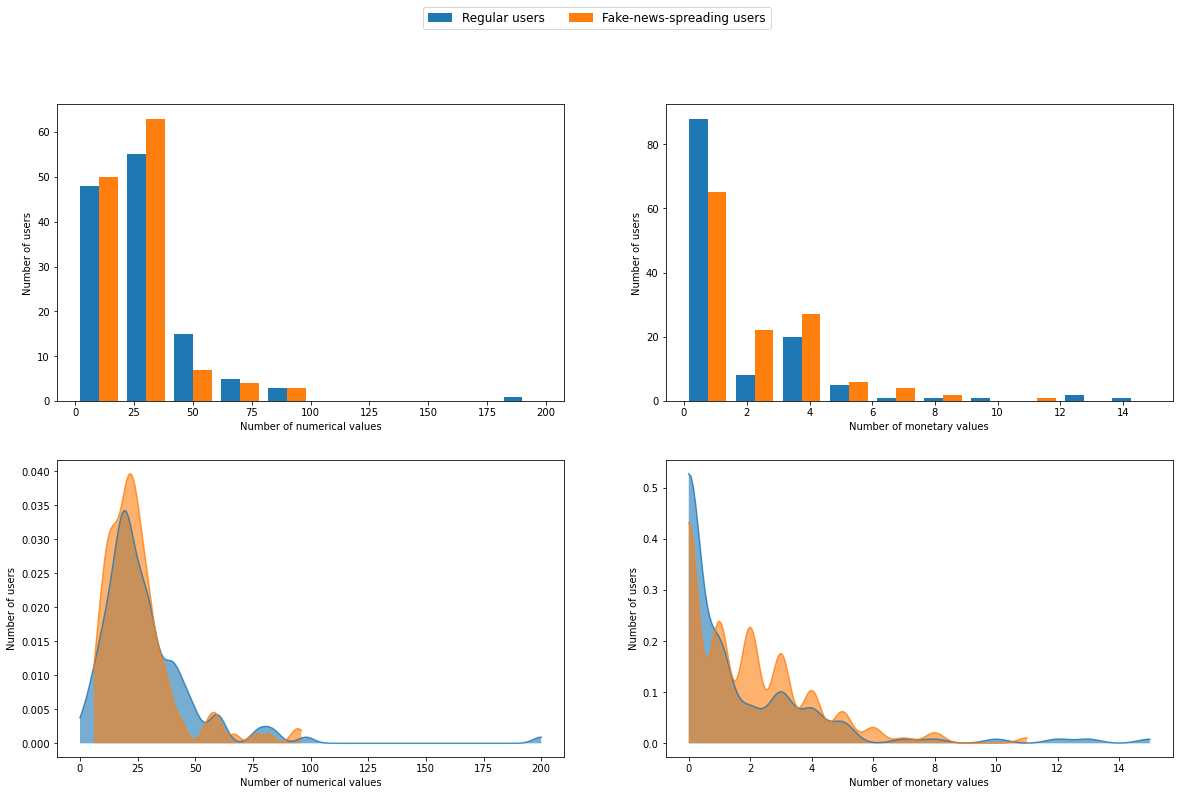

In [518]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 12))

values = ["numerical", "monetary"]
for i in range(x_numbers.shape[-1]):
    ax[0][i].hist([x_numbers[y == 0, i], x_numbers[y == 1, i]], label=["Regular users", "Fake-news-spreading users"])
    ax[0][i].set_ylabel("Number of users")
    ax[0][i].set_xlabel(f"Number of {values[i]} values")
    
    density_plot(x_numbers[:, i], 
                 axes=ax[1][i],
                 xlabel=f"Number of {values[i]} values",
                 ylabel="Number of users",
                 labels=["Regular users", "Fake-news-spreading users"])

fig.legend(*ax[0, 0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=12)

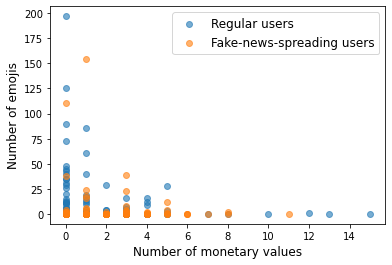

In [519]:
# fig = plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(x_numbers[y==0, -1], x_emoji_counts[y==0], alpha=0.6, label="Regular users")
plt.scatter(x_numbers[y==1, -1], x_emoji_counts[y==1], alpha=0.6, label="Fake-news-spreading users")
plt.xlabel("Number of monetary values", fontsize=12)
plt.ylabel("Number of emojis", fontsize=12)
plt.legend(fontsize=12)

### Readability measurements

#### Syllables to words ratio

In [520]:
extractor = ex.TweetStatsExtractor([read.syllables_to_words_ratios])
x_syllables_to_words = extractor.transform(x)

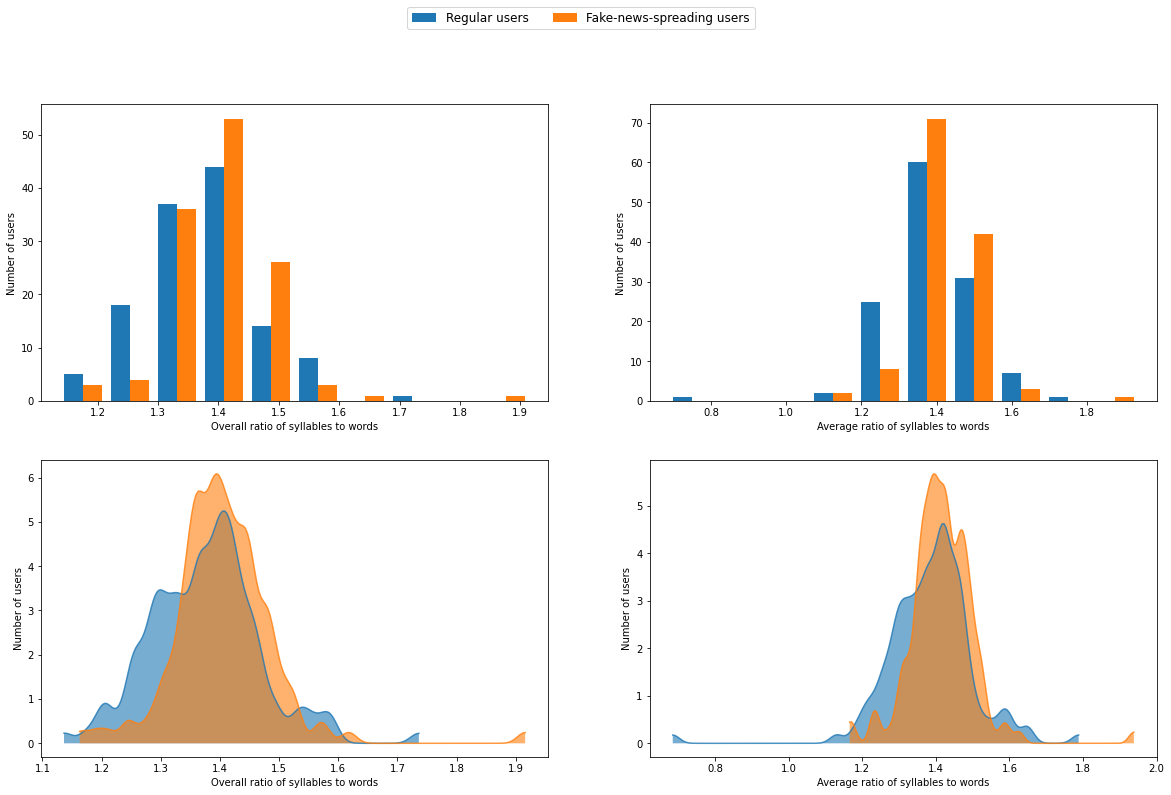

In [521]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 12))

labels = ["Overall ratio of syllables to words", "Average ratio of syllables to words"]
for i in range(x_numbers.shape[-1]):
    ax[0][i].hist([x_syllables_to_words[y == 0, i], x_syllables_to_words[y == 1, i]], 
               label=["Regular users", "Fake-news-spreading users"])
    ax[0][i].set_ylabel("Number of users")
    ax[0][i].set_xlabel(labels[i])
    
    density_plot(x_syllables_to_words[:, i], 
             axes=ax[1][i],
             xlabel=labels[i],
             ylabel="Number of users",
             labels=["Regular users", "Fake-news-spreading users"])

fig.legend(*ax[0, 0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=12)

In [541]:
# fig = plt.figure(figsize=(8, 6), dpi=300)
# density_plot(x_syllables_to_words[:, 0], 
#              labels=["Regular users", "Fake-news-spreading users"])
# plt.ylabel("Density", fontsize=12)
# plt.xlabel("Ratio of syllables to words", fontsize=12)
# plt.legend(fontsize=12)

#### Characters to words

In [523]:
extractor = ex.TweetStatsExtractor([read.char_to_words_ratio])
x_chars_to_words = extractor.transform(x).flatten()

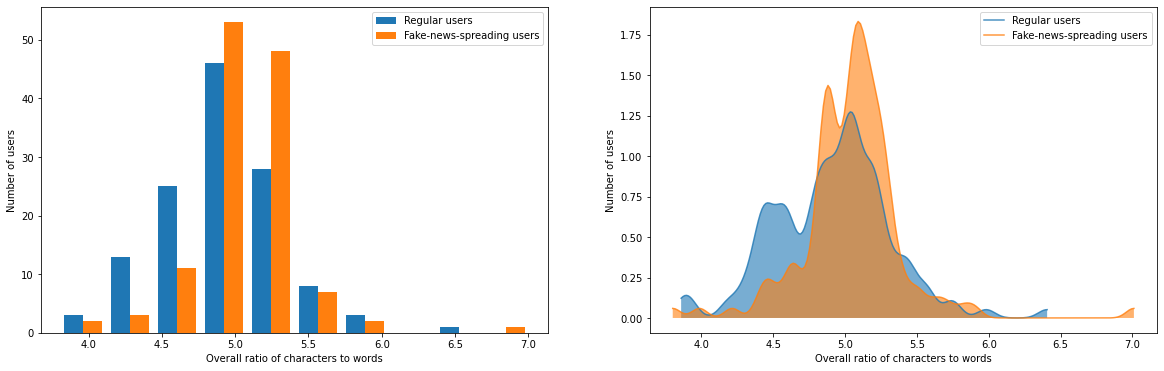

In [524]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 6))

ax[0].hist([x_chars_to_words[y == 0], x_chars_to_words[y == 1]], label=["Regular users", "Fake-news-spreading users"])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Overall ratio of characters to words")

density_plot(x_chars_to_words, 
             axes=ax[1],
             xlabel="Overall ratio of characters to words",
             ylabel="Number of users",
             labels=["Regular users", "Fake-news-spreading users"])

ax[0].legend()
ax[1].legend()

In [544]:
# fig = plt.figure(figsize=(8, 6), dpi=300)
# density_plot(x_chars_to_words, 
#              labels=["Regular users", "Fake-news-spreading users"])
# plt.ylabel("Density", fontsize=12)
# plt.xlabel("Ratio of characters to words", fontsize=12)
# plt.legend(fontsize=12)

#### Punctuation usage 

In [526]:
extractor = ex.TweetStatsExtractor([lambda tweet_feed: read.punctuation_counts(tweet_feed)[:-1]])
x_punctuation = extractor.transform(x)

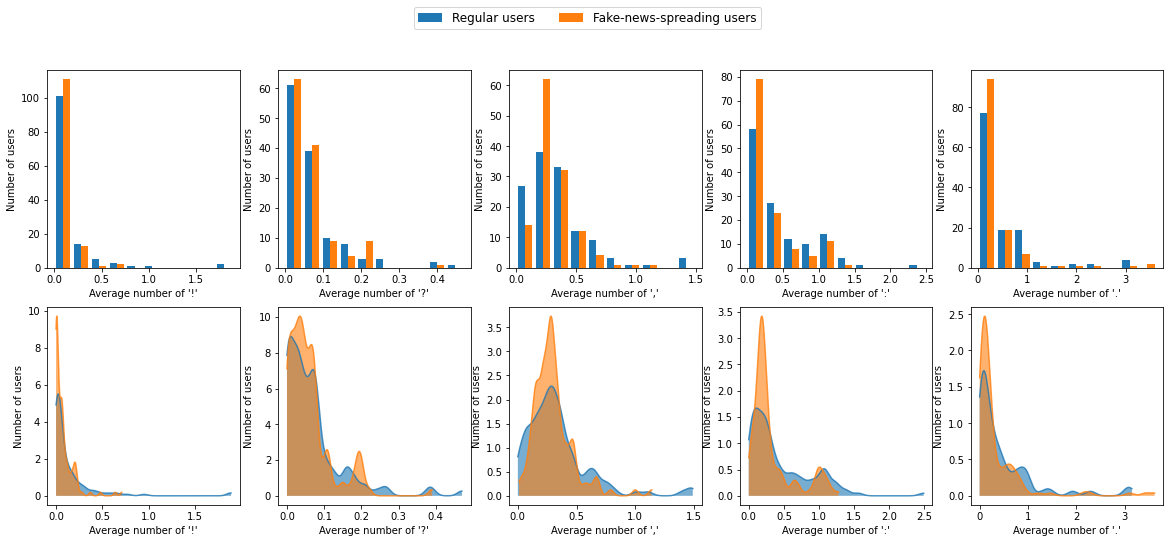

In [527]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(20, 8))

punc = ["!", "?", ",", ":", "."]
for i in range(x_punctuation.shape[-1]):
    ax[0, i].hist([x_punctuation[y == 0, i], x_punctuation[y == 1, i]], 
               label=["Regular users", "Fake-news-spreading users"])
    ax[0, i].set_ylabel("Number of users")
    ax[0, i].set_xlabel(f"Average number of '{punc[i]}'")
    
    density_plot(x_punctuation[:, i], 
                 axes=ax[1, i],
                 xlabel=f"Average number of '{punc[i]}'",
                 ylabel="Number of users",
                 labels=["Regular users", "Fake-news-spreading users"])

fig.legend(*ax[0, 0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=12)

#### Personal pronouns

In [545]:
extractor = ex.TweetStatsExtractor([read.average_personal_pronouns])
x_personal_pronouns = extractor.transform(x).flatten()

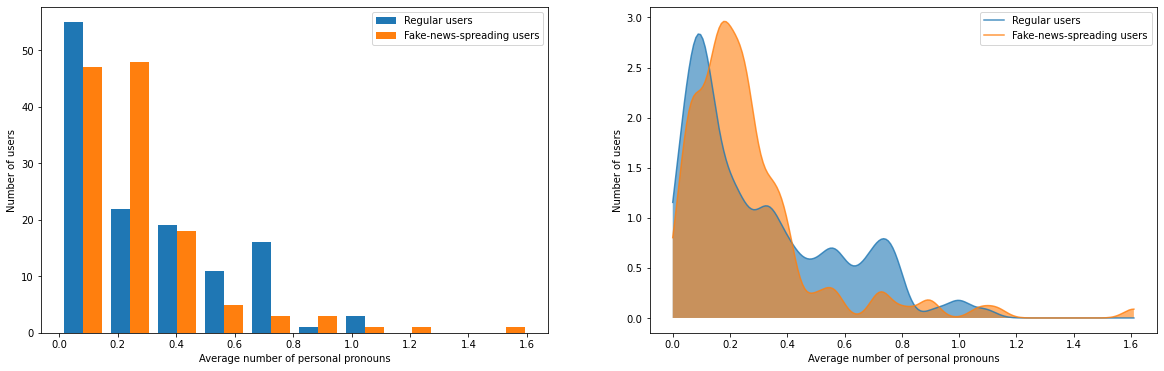

In [546]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 6))

ax[0].hist([x_personal_pronouns[y == 0], x_personal_pronouns[y == 1]], label=["Regular users", "Fake-news-spreading users"])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Average number of personal pronouns")

density_plot(x_personal_pronouns, 
             axes=ax[1],
             xlabel="Average number of personal pronouns",
             ylabel="Number of users",
             labels=["Regular users", "Fake-news-spreading users"])

ax[0].legend()
ax[1].legend()

In [ ]:
# fig = plt.figure(figsize=(8, 6), dpi=300)
# plt.hist([x_personal_pronouns[y == 0], x_personal_pronouns[y == 1]], 
#          label=["Regular users", "Fake-news-spreading users"])
# plt.ylabel("Number of users", fontsize=12)
# plt.xlabel("Average number of personal pronouns", fontsize=12)
# plt.legend(fontsize=12)

#### Word capitalisation

In [547]:
extractor = ex.TweetStatsExtractor([read.capitalisation_counts])
x_capital = extractor.transform(x)

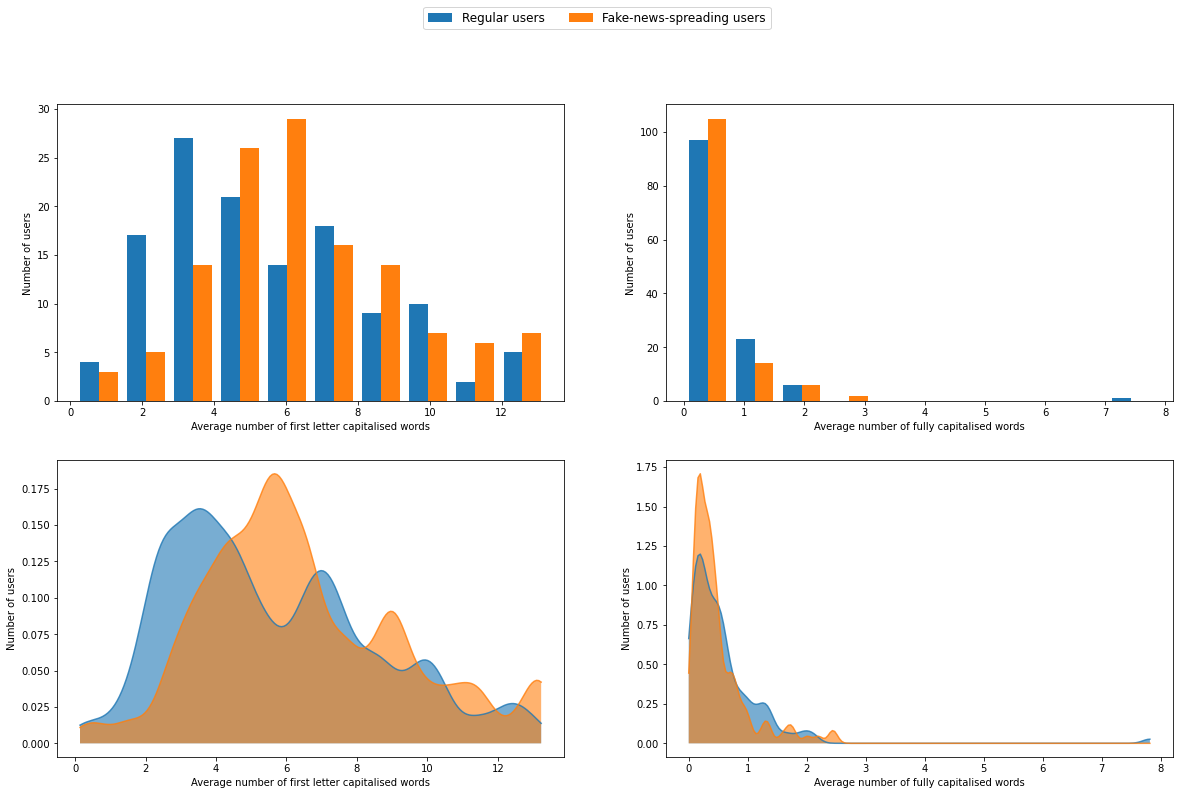

In [548]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 12))

label = ["Average number of first letter capitalised words", "Average number of fully capitalised words"]
for i in range(x_capital.shape[-1]):
    ax[0, i].hist([x_capital[y == 0, i], x_capital[y == 1, i]], 
               label=["Regular users", "Fake-news-spreading users"])
    ax[0, i].set_ylabel("Number of users")
    ax[0, i].set_xlabel(label[i])
    
    density_plot(x_capital[:, i], 
                 axes=ax[1, i],
                 xlabel=label[i],
                 ylabel="Number of users",
                 labels=["Regular users", "Fake-news-spreading users"])

fig.legend(*ax[0, 0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=12)

In [566]:
# i = 0
# fig = plt.figure(figsize=(8, 6), dpi=300)
# density_plot(x_capital[:, i], 
#              labels=["Regular users", "Fake-news-spreading users"])
# plt.ylabel("Density", fontsize=12)
# plt.xlabel(label[i], fontsize=12)
# plt.legend(fontsize=12)

### Uniqueness features

#### Word TTR

In [549]:
extractor = ex.TweetStatsExtractor([read.word_type_to_token_ratio])
x_word_ttr = extractor.transform(x).flatten()

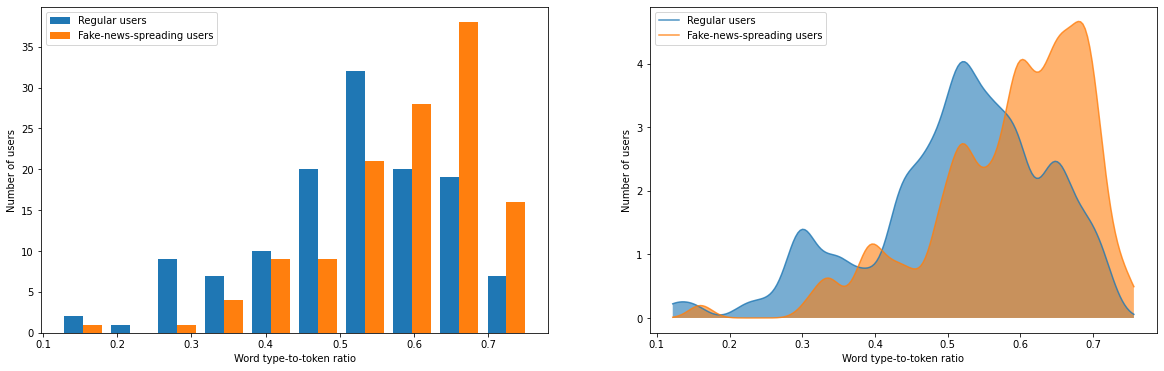

In [550]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 6))

ax[0].hist([x_word_ttr[y == 0], x_word_ttr[y == 1]], label=["Regular users", "Fake-news-spreading users"])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Word type-to-token ratio")

density_plot(x_word_ttr, 
             axes=ax[1],
             xlabel="Word type-to-token ratio",
             ylabel="Number of users",
             labels=["Regular users", "Fake-news-spreading users"])

ax[0].legend()
ax[1].legend()

In [570]:
# fig = plt.figure(figsize=(8, 6), dpi=300)
# density_plot(x_word_ttr, 
#              labels=["Regular users", "Fake-news-spreading users"])
# plt.ylabel("Density", fontsize=12)
# plt.xlabel("Word type-to-token ratio", fontsize=12)
# plt.legend(fontsize=12)

#### Punctuation TTR

In [552]:
extractor = ex.TweetStatsExtractor([lambda tweet_feed: read.punctuation_counts(tweet_feed)[-1]])
x_punctuation_ttr = extractor.transform(x).flatten()

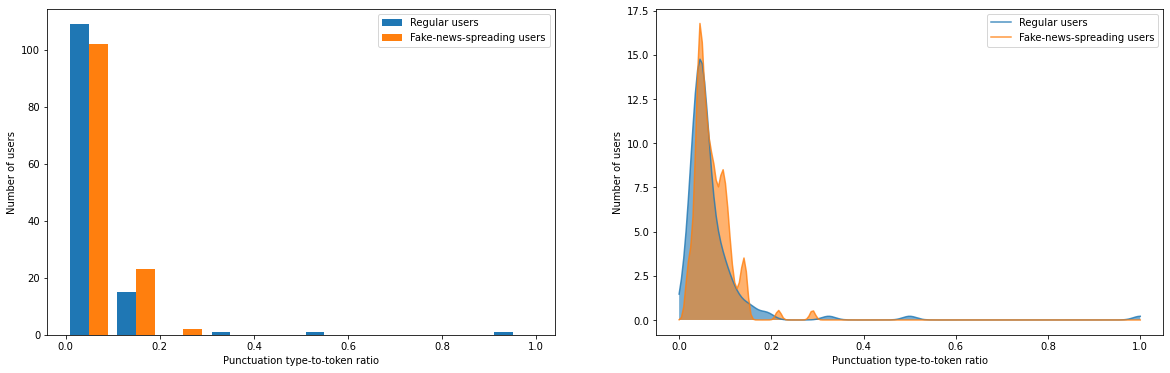

In [553]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 6))

ax[0].hist([x_punctuation_ttr[y == 0], x_punctuation_ttr[y == 1]], label=["Regular users", "Fake-news-spreading users"])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Punctuation type-to-token ratio")

density_plot(x_punctuation_ttr, 
             axes=ax[1],
             xlabel="Punctuation type-to-token ratio",
             ylabel="Number of users",
             labels=["Regular users", "Fake-news-spreading users"])

ax[0].legend()
ax[1].legend()

In [572]:
# fig = plt.figure(figsize=(8, 6), dpi=300)
# density_plot(x_punctuation_ttr, 
#              labels=["Regular users", "Fake-news-spreading users"])
# plt.ylabel("Density", fontsize=12)
# plt.xlabel("Punctuation type-to-token ratio", fontsize=12)
# plt.legend(fontsize=12)

#### Emoji TTR

In [555]:
extractor = ex.TweetStatsExtractor([lambda tweet_feed: read.emojis_counts(tweet_feed)[-1]])
x_emoji_ttr = extractor.transform(x).flatten()

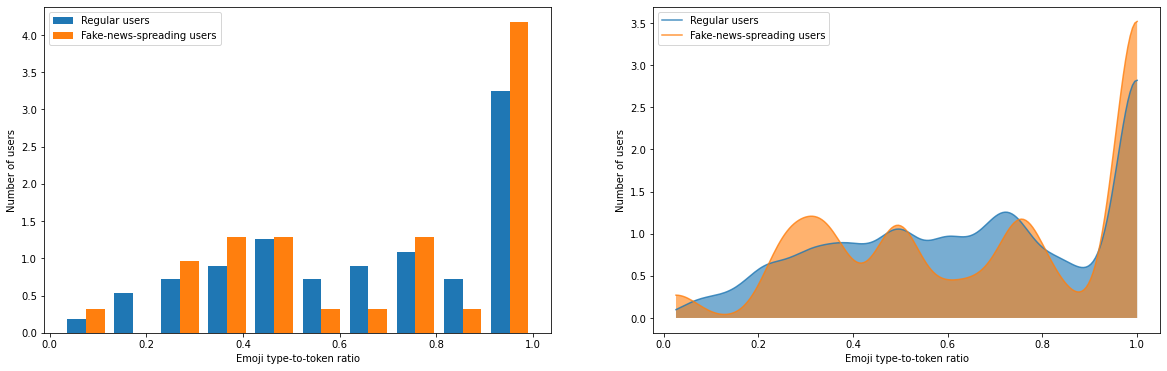

In [589]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 6))

# Ignore users who don't use emojis
x_emoji_ttr_truth = x_emoji_ttr[y == 0]
x_emoji_ttr_truth = x_emoji_ttr_truth[x_emoji_ttr_truth > 0]
x_emoji_ttr_fake = x_emoji_ttr[y == 1]
x_emoji_ttr_fake = x_emoji_ttr_fake[x_emoji_ttr_fake > 0]

ax[0].hist([x_emoji_ttr_truth, x_emoji_ttr_fake], label=["Regular users", "Fake-news-spreading users"],
          density=True)
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Emoji type-to-token ratio")

density_plot((x_emoji_ttr_truth, x_emoji_ttr_fake), 
             axes=ax[1],
             xlabel="Emoji type-to-token ratio",
             ylabel="Number of users",
             labels=["Regular users", "Fake-news-spreading users"])

ax[0].legend()
ax[1].legend()

In [591]:
# fig = plt.figure(figsize=(8, 6), dpi=300)
# density_plot((x_emoji_ttr_truth, x_emoji_ttr_fake), 
#              labels=["Regular users", "Fake-news-spreading users"])
# plt.ylabel("Density", fontsize=12)
# plt.xlabel("Emoji type-to-token ratio", fontsize=12)
# plt.legend(fontsize=12)

#### Retweet ratio

In [7]:
extractor = ex.TweetStatsExtractor([read.retweet_ratio])
x_retweet = extractor.transform(x).flatten()

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 6))

ax[0].hist([x_retweet[y == 0], x_retweet[y == 1]], label=["Regular users", "Fake-news-spreading users"])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Overall retweet ratio")

density_plot(x_retweet, 
             axes=ax[1],
             xlabel="Overall retweet ratio",
             ylabel="Number of users",
             labels=["Regular users", "Fake-news-spreading users"])

ax[0].legend()
ax[1].legend()

In [9]:
# fig = plt.figure(figsize=(8, 6), dpi=300)
# density_plot(x_retweet, 
#              labels=["Regular users", "Fake-news-spreading users"])
# plt.ylabel("Density", fontsize=12)
# plt.xlabel("Ratio of retweets to tweets", fontsize=12)
# plt.legend(fontsize=12)

#### Quotes

In [10]:
extractor = ex.TweetStatsExtractor([read.quote_counts])
x_quotes = extractor.transform(x).flatten()

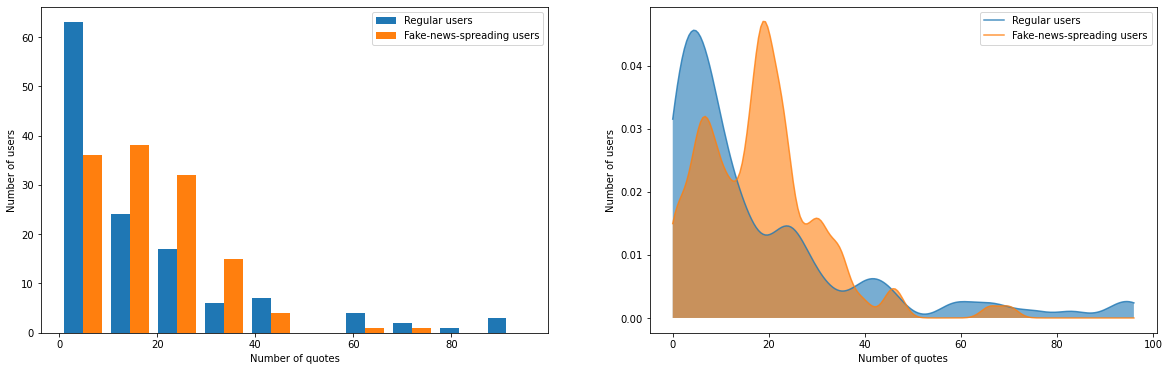

In [562]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 6))

ax[0].hist([x_quotes[y == 0], x_quotes[y == 1]], label=["Regular users", "Fake-news-spreading users"])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Number of quotes")

density_plot(x_quotes, 
             axes=ax[1],
             xlabel="Number of quotes",
             ylabel="Number of users",
             labels=["Regular users", "Fake-news-spreading users"])

ax[0].legend()
ax[1].legend()

In [12]:
# fig = plt.figure(figsize=(8, 6), dpi=300)
# density_plot(x_quotes, 
#              labels=["Regular users", "Fake-news-spreading users"])
# plt.ylabel("Density", fontsize=12)
# plt.xlabel("Number of quotes", fontsize=12)
# plt.legend(fontsize=12)

## Fitted model

### Correlation matrix of readability features

In [41]:
extractor = read.readability_tweet_extractor()
x_read = extractor.transform(x)

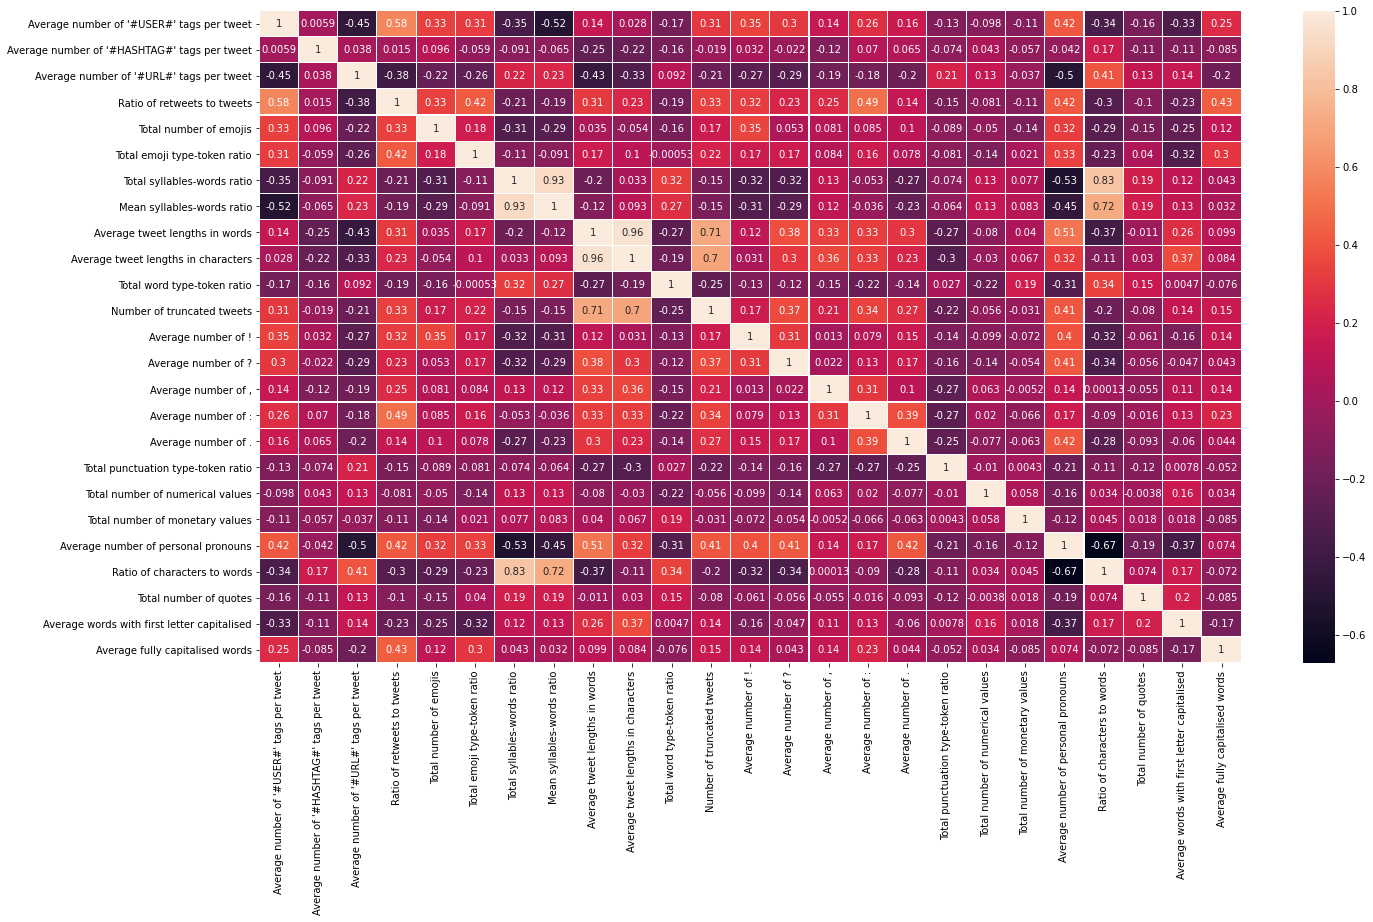

In [46]:
correlation_matrix(x_read, extractor.feature_names)

In [ ]:
predictions = fit_model(
    "../../training/statistical/readability_10/trial_0be075eee1b0230e51a4517cc721c747/trial.json", "readability")

In [ ]:
plot_roc(predictions)

In [597]:
plot_confusion_matrix(predictions)

NameError: name 'predictions' is not defined

# Sentiment Model

## Feature plots

In [14]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
x_tweet_sentiment = np.asarray([
    [list(analyser.polarity_scores(tweet).values()) for tweet in tweet_feed] for tweet_feed in x])
x_tweet_sentiment_means = np.mean(x_tweet_sentiment, axis=1)
x_tweet_sentiment_std = np.std(x_tweet_sentiment, axis=1)
# [neg, neu, pos, compound]

#### Average sentiments

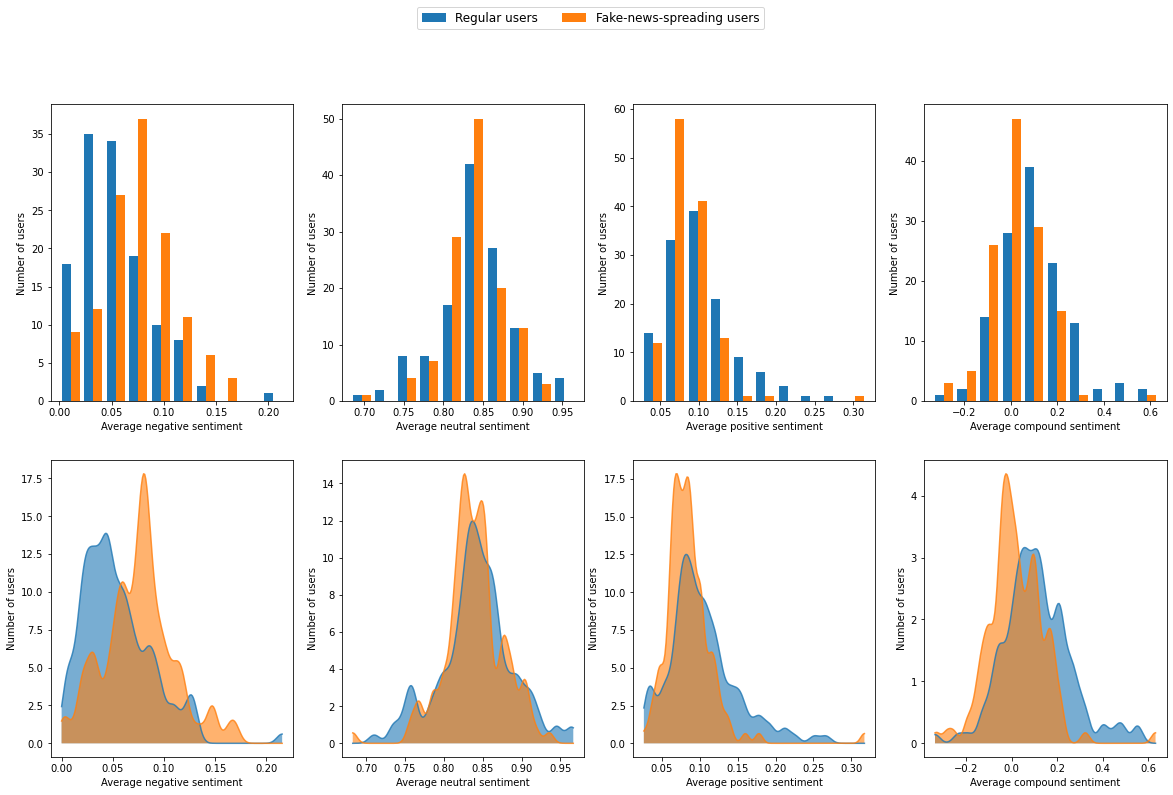

In [15]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 12))

sent = ["negative", "neutral", "positive", "compound"]
for i in range(4):
    ax[0, i].hist([x_tweet_sentiment_means[y == 0, i], x_tweet_sentiment_means[y == 1, i]], 
               label=["Regular users", "Fake-news-spreading users"])
    ax[0, i].set_ylabel("Number of users")
    ax[0, i].set_xlabel(f"Average {sent[i]} sentiment")
    
    density_plot(x_tweet_sentiment_means[:, i], 
                 axes=ax[1, i],
                 xlabel=f"Average {sent[i]} sentiment",
                 ylabel="Number of users",
                 labels=["Regular users", "Fake-news-spreading users"])

fig.legend(*ax[0, 0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=12)

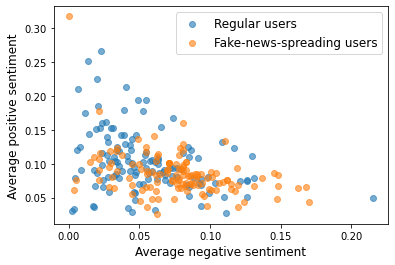

In [18]:
# fig = plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(x_tweet_sentiment_means[y == 0, 0], x_tweet_sentiment_means[y == 0, 2], 
            alpha=0.6, label="Regular users")
plt.scatter(x_tweet_sentiment_means[y == 1, 0], x_tweet_sentiment_means[y == 1, 2], 
            alpha=0.6, label="Fake-news-spreading users")
plt.xlabel("Average negative sentiment", fontsize=12)
plt.ylabel("Average positive sentiment", fontsize=12)
plt.legend(fontsize=12)

#### Standard deviation of sentiments

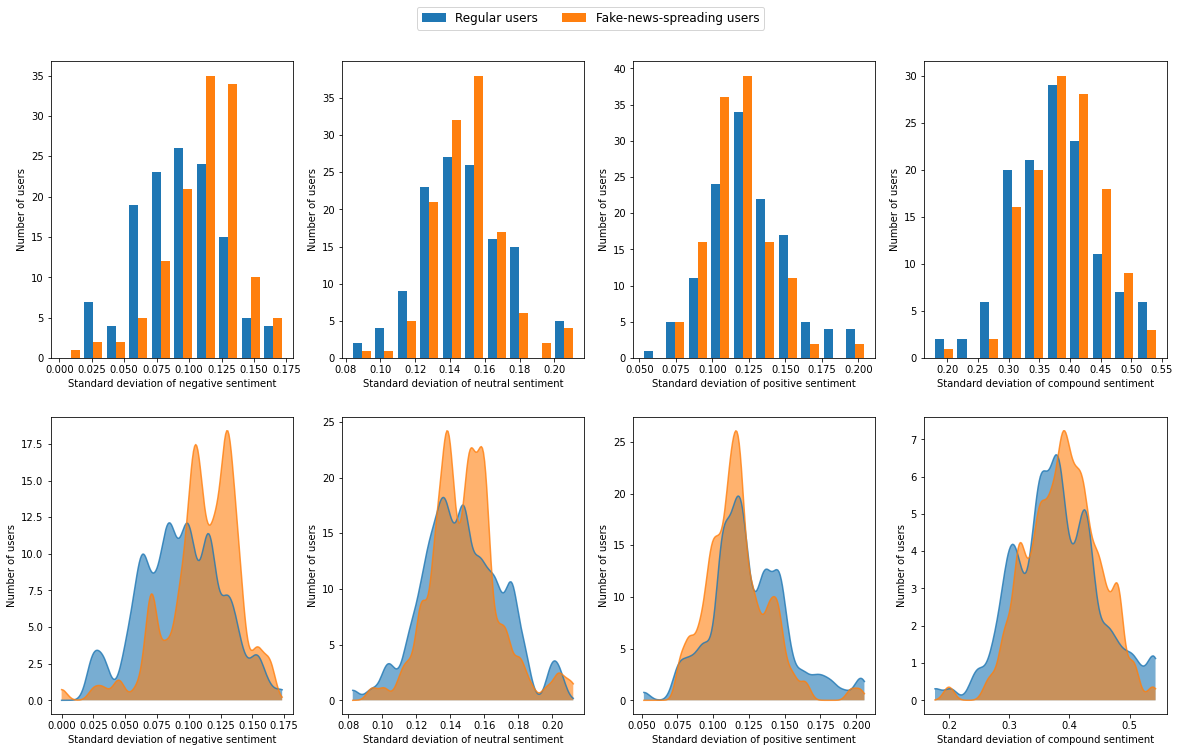

In [606]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 12))

for i in range(4):
    ax[0, i].hist([x_tweet_sentiment_std[y == 0, i], x_tweet_sentiment_std[y == 1, i]], 
               label=["Regular users", "Fake-news-spreading users"])
    ax[0, i].set_ylabel("Number of users")
    ax[0, i].set_xlabel(f"Standard deviation of {sent[i]} sentiment")
    
    density_plot(x_tweet_sentiment_std[:, i], 
                 axes=ax[1, i],
                 xlabel=f"Standard deviation of {sent[i]} sentiment",
                 ylabel="Number of users",
                 labels=["Regular users", "Fake-news-spreading users"])

fig.legend(*ax[0, 0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=12)

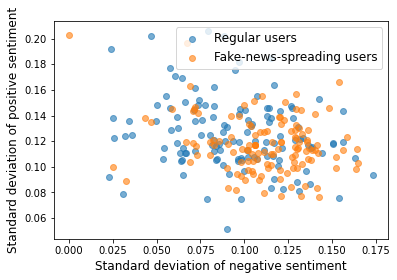

In [23]:
# fig = plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(x_tweet_sentiment_std[y == 0, 0], x_tweet_sentiment_std[y == 0, 2], 
            alpha=0.6, label="Regular users")
plt.scatter(x_tweet_sentiment_std[y == 1, 0], x_tweet_sentiment_std[y == 1, 2], 
            alpha=0.6, label="Fake-news-spreading users")
plt.xlabel("Standard deviation of negative sentiment", fontsize=12)
plt.ylabel("Standard deviation of positive sentiment", fontsize=12)
plt.legend(fontsize=12)

#### Range of sentiments

In [608]:
x_sentiment_ranges = np.max(x_tweet_sentiment, axis=1) - np.min(x_tweet_sentiment, axis=1)

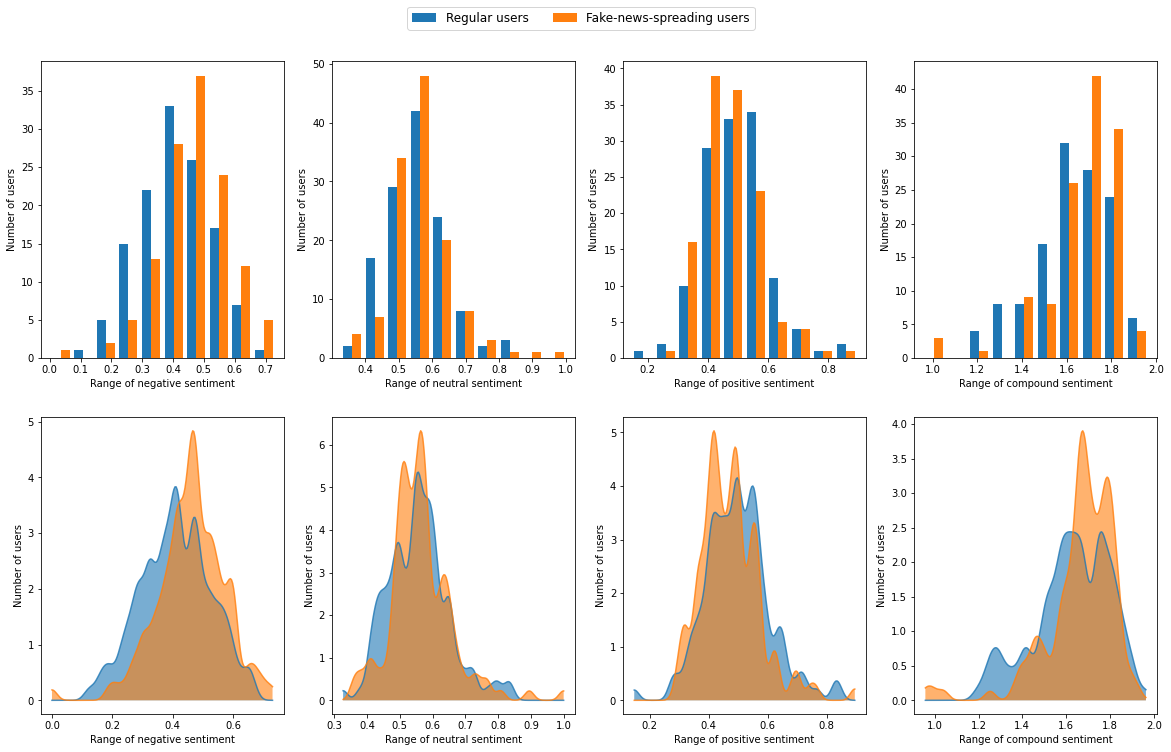

In [609]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 12))

for i in range(4):
    ax[0, i].hist([x_sentiment_ranges[y == 0, i], x_sentiment_ranges[y == 1, i]], 
               label=["Regular users", "Fake-news-spreading users"])
    ax[0, i].set_ylabel("Number of users")
    ax[0, i].set_xlabel(f"Range of {sent[i]} sentiment")
    
    density_plot(x_sentiment_ranges[:, i], 
                 axes=ax[1, i],
                 xlabel=f"Range of {sent[i]} sentiment",
                 ylabel="Number of users",
                 labels=["Regular users", "Fake-news-spreading users"])

fig.legend(*ax[0, 0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=12)

#### Max sentiments

In [610]:
x_sentiment_max = np.max(x_tweet_sentiment, axis=1)[:, [0, 2, 3]]

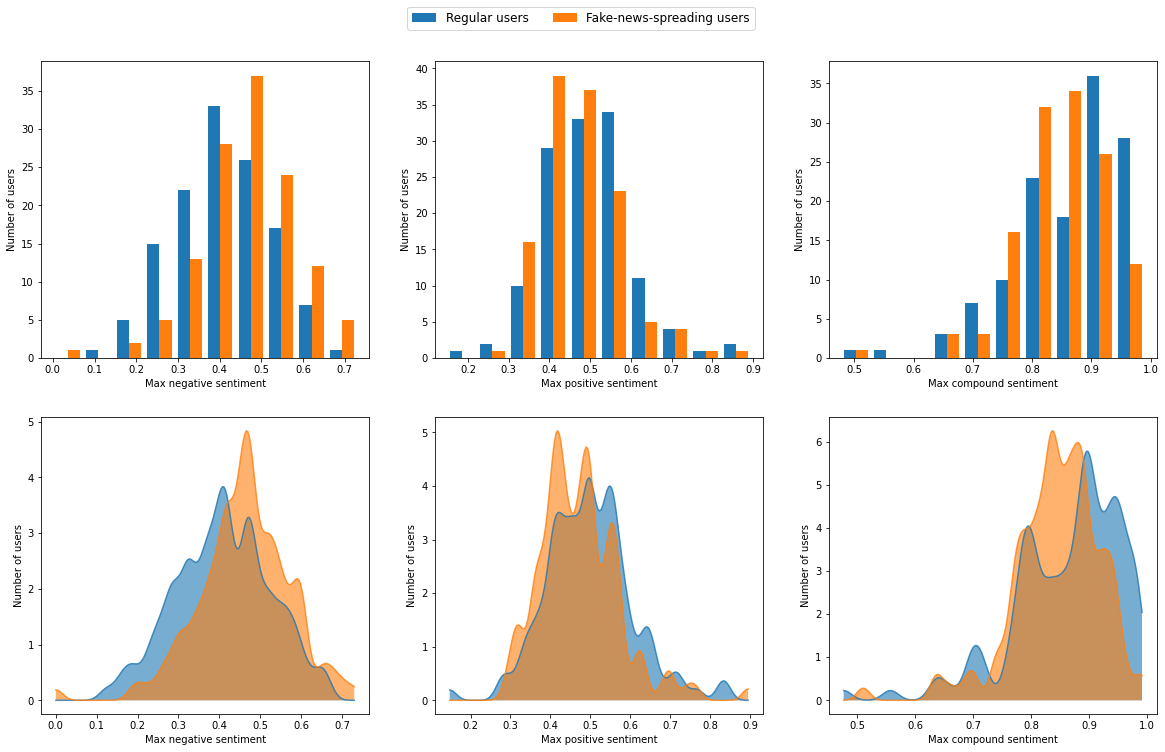

In [611]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 12))

sent = ["negative", "positive", "compound"]
for i in range(3):
    ax[0, i].hist([x_sentiment_max[y == 0, i], x_sentiment_max[y == 1, i]], 
               label=["Regular users", "Fake-news-spreading users"])
    ax[0, i].set_ylabel("Number of users")
    ax[0, i].set_xlabel(f"Max {sent[i]} sentiment")
    
    density_plot(x_sentiment_max[:, i], 
                 axes=ax[1, i],
                 xlabel=f"Max {sent[i]} sentiment",
                 ylabel="Number of users",
                 labels=["Regular users", "Fake-news-spreading users"])

fig.legend(*ax[0, 0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=12)

#### Tweet polarity counts

In [25]:
x_polarity_counts = np.full((len(x), 3), 0)
for i, tweet_feed_scores in enumerate(x_tweet_sentiment):
    for tweet_scores in tweet_feed_scores:
        compound = tweet_scores[-1]
        if compound >= 0.05:
            x_polarity_counts[i, 2] += 1  # Pos
        elif compound <= -0.05:
            x_polarity_counts[i, 0] += 1  # Neg
        else:
            x_polarity_counts[i, 1] += 1  # Neu

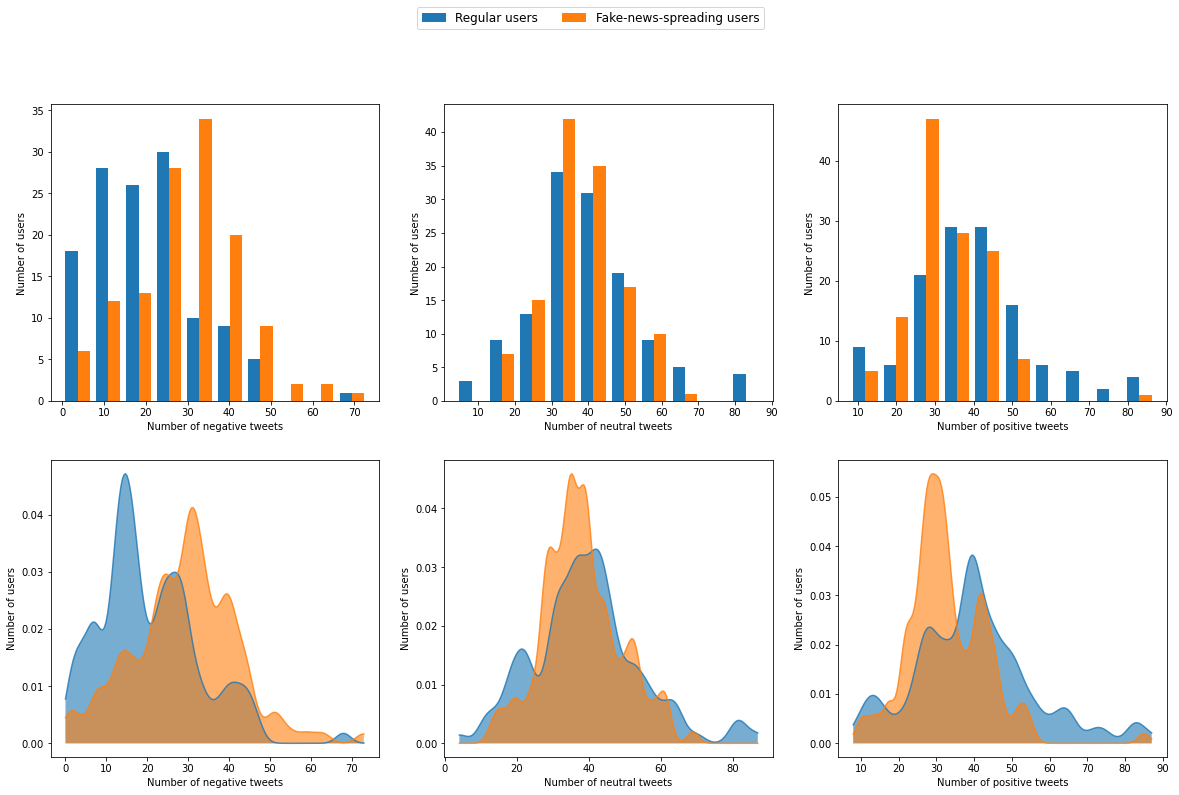

In [26]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 12))

sent = ["negative", "neutral", "positive"]
for i in range(x_polarity_counts.shape[-1]):
    ax[0, i].hist([x_polarity_counts[y == 0, i], x_polarity_counts[y == 1, i]], 
               label=["Regular users", "Fake-news-spreading users"])
    ax[0, i].set_ylabel("Number of users")
    ax[0, i].set_xlabel(f"Number of {sent[i]} tweets")
    
    density_plot(x_polarity_counts[:, i], 
                 axes=ax[1, i],
                 xlabel=f"Number of {sent[i]} tweets",
                 ylabel="Number of users",
                 labels=["Regular users", "Fake-news-spreading users"])

fig.legend(*ax[0, 0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=12)

In [29]:
# i = 2
# fig = plt.figure(figsize=(8, 6), dpi=300)
# density_plot(x_polarity_counts[:, i], 
#              labels=["Regular users", "Fake-news-spreading users"])
# plt.ylabel("Density", fontsize=12)
# plt.xlabel(f"Number of {sent[i]} tweets", fontsize=12)
# plt.legend(fontsize=12)

#### Overall user sentiment

In [614]:
x_user_sentiment = np.asarray(
    [list(analyser.polarity_scores(" ".join(tweet_feed)).values()) for tweet_feed in x])

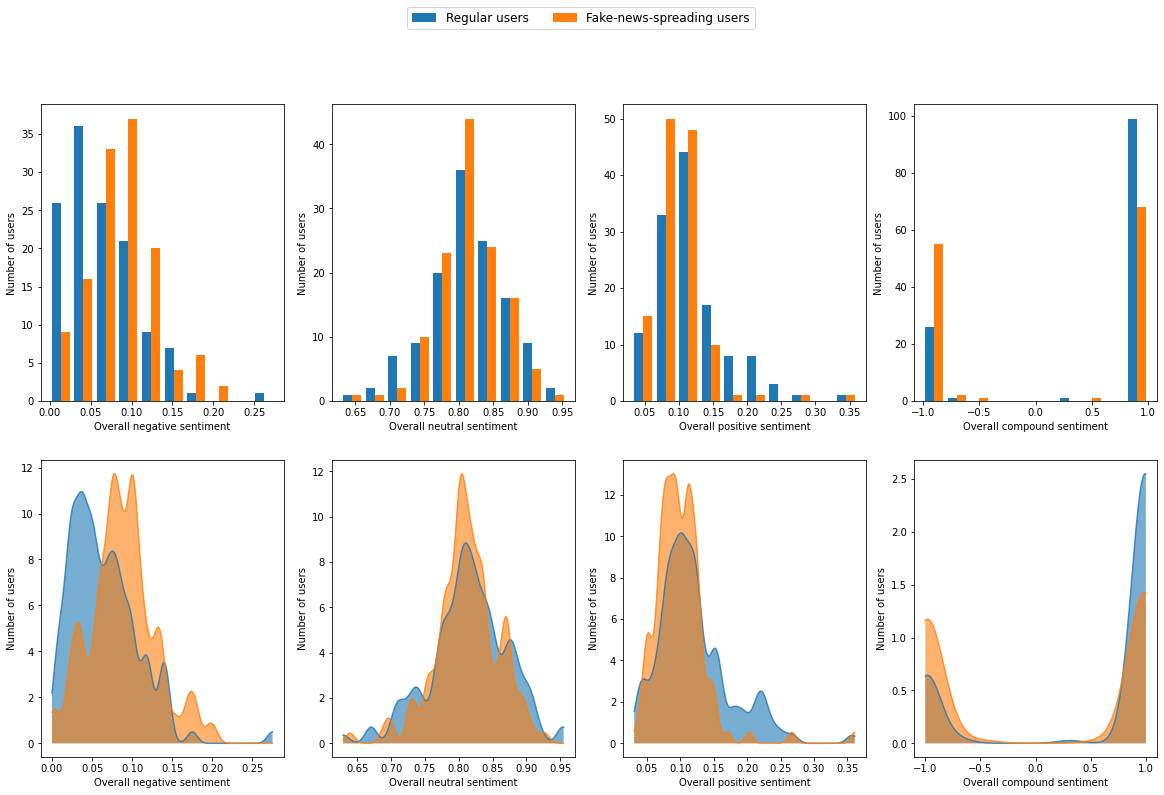

In [615]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 12))

sent = ["negative", "neutral", "positive", "compound"]
for i in range(4):
    ax[0, i].hist([x_user_sentiment[y == 0, i], x_user_sentiment[y == 1, i]], 
               label=["Regular users", "Fake-news-spreading users"])
    ax[0, i].set_ylabel("Number of users")
    ax[0, i].set_xlabel(f"Overall {sent[i]} sentiment")
    
    density_plot(x_user_sentiment[:, i], 
                 axes=ax[1, i],
                 xlabel=f"Overall {sent[i]} sentiment",
                 ylabel="Number of users",
                 labels=["Regular users", "Fake-news-spreading users"])

fig.legend(*ax[0, 0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=12)

## Fitted model

In [56]:
from functools import partial
import statistical.data_extraction.sentiment.sentiment as sent
from statistical.data_extraction.sentiment.vader import VaderSentimentAnalysisWrapper

In [57]:
sentiment_wrapper = VaderSentimentAnalysisWrapper()
extractor = ex.TweetStatsExtractor([
    partial(sent.tweet_sentiment_scores, sentiment_wrapper=sentiment_wrapper),
    partial(sent.overall_compound_sentiment_score, sentiment_wrapper=sentiment_wrapper),
])
extractor.feature_names = [
    "Average negative sentiment",
    "Average positive sentiment",
    "Average compound sentiment",
    "Std negative sentiment",
    "Std positive sentiment",
    "Std compound sentiment",
    "Min compound sentiment",
    "Max negative sentiment",
    "Max positive sentiment",
    "Max compound sentiment",
    "Num negative tweets",
    "Num neutral tweets",
    "Num positive tweets",
    "Overall compound sentiment"
]
x_sent = extractor.transform(x)

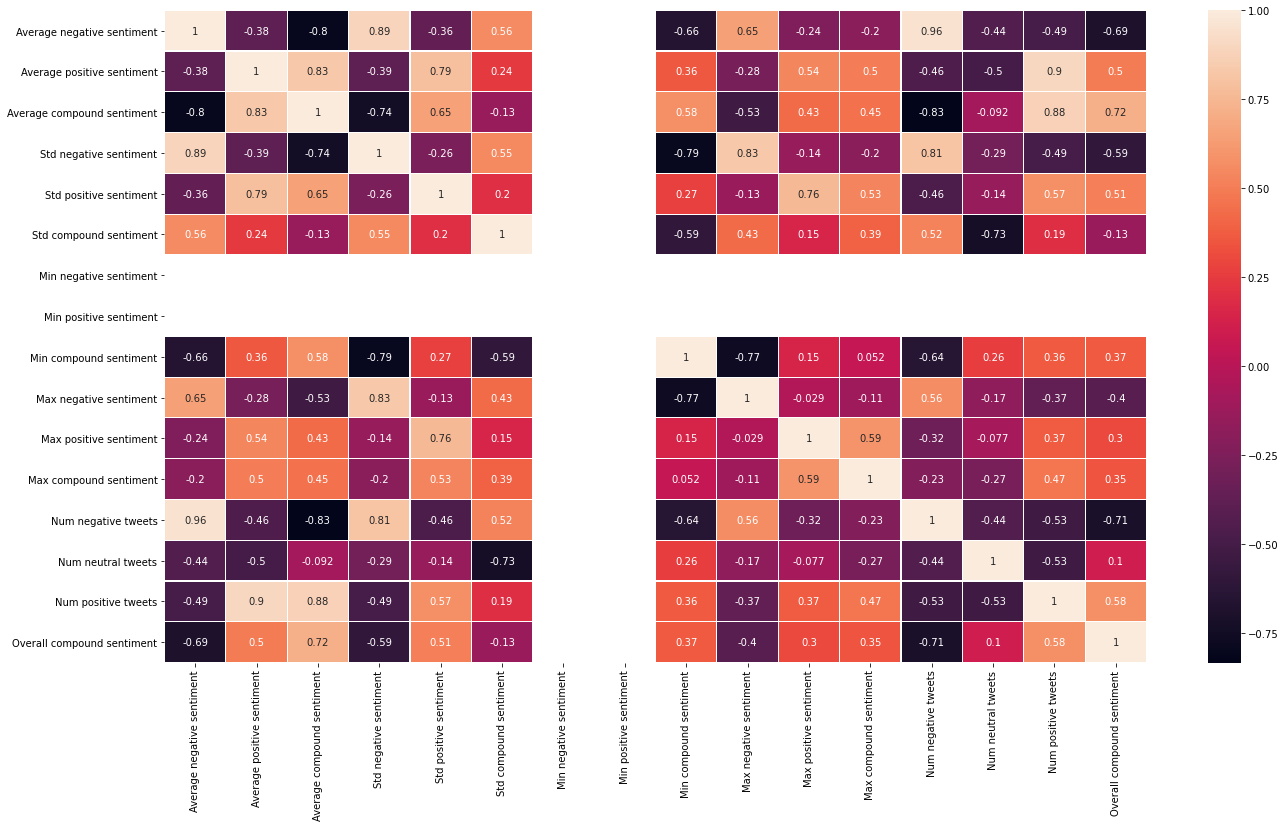

In [58]:
correlation_matrix(x_sent, extractor.feature_names)

# NER Model

In [616]:
from functools import partial

from statistical.data_extraction.ner.stanza import StanzaNerTaggerWrapper
from statistical.data_extraction.ner.named_entity import named_entities_counts, aggregated_named_entities_counts

## Data plots

In [617]:
StanzaNerTaggerWrapper = StanzaNerTaggerWrapper()
extractor = ex.TweetStatsExtractor([partial(named_entities_counts, ner_tagger=ner_tagger)])
x_ner_counts = extractor.transform(x)

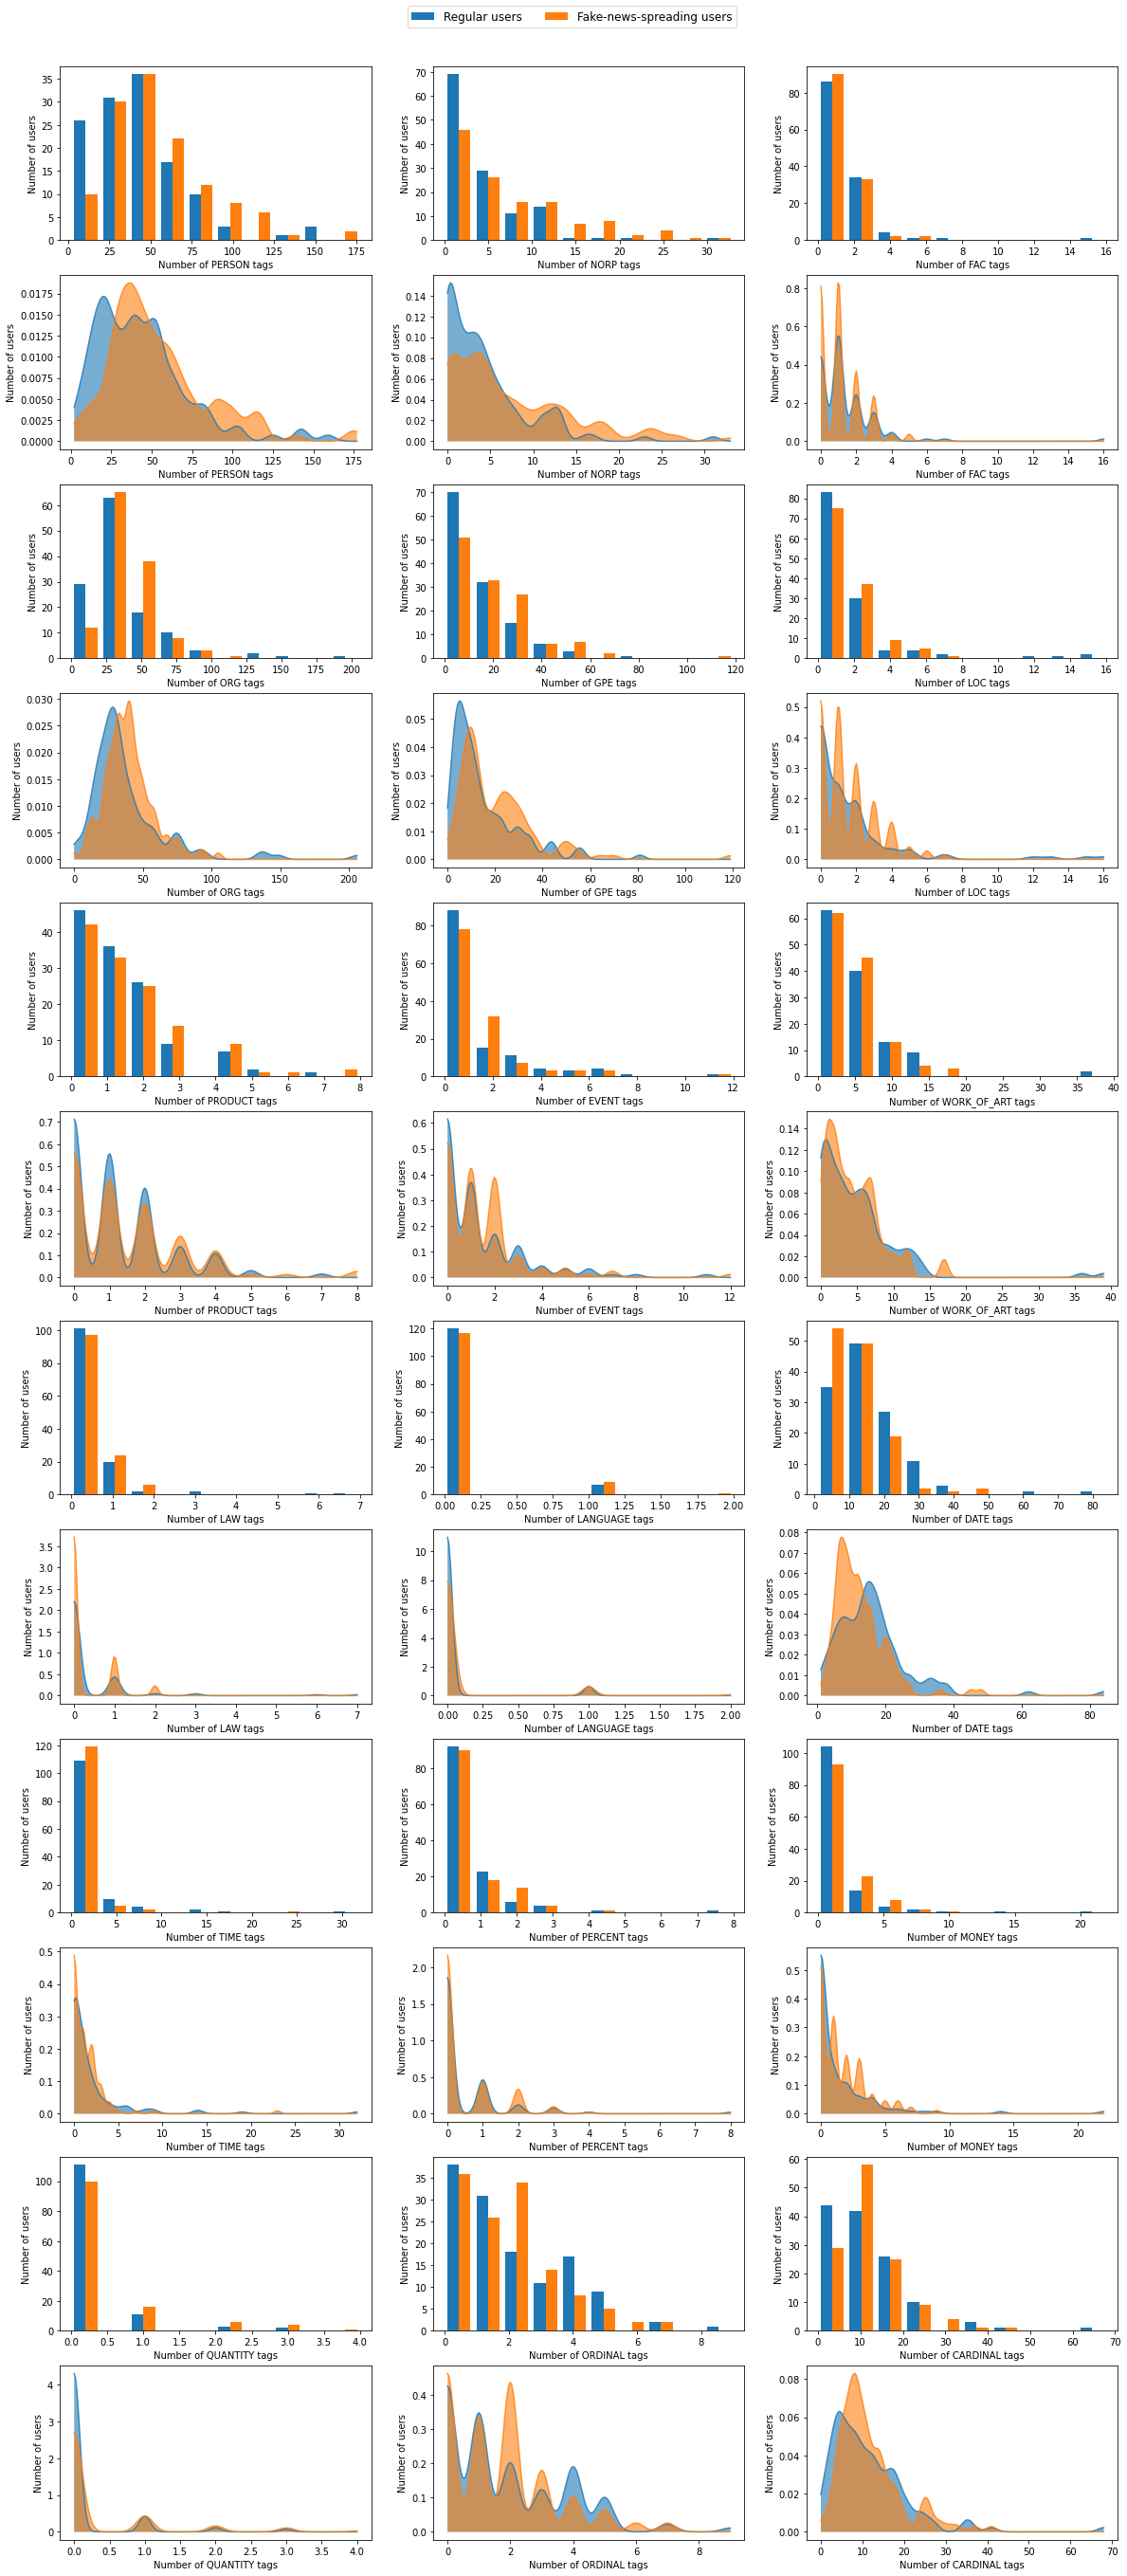

In [618]:
fig, ax = plt.subplots(ncols=3, nrows=(x_ner_counts.shape[-1] // 3) * 2, figsize=(20, 48))

row = 0
for i in range(x_ner_counts.shape[-1]):
    if i % 3 == 0 and i != 0:
        row += 2
    col = i % 3
    ax[row, col].hist([x_ner_counts[y == 0, i], x_ner_counts[y == 1, i]], 
               label=["Regular users", "Fake-news-spreading users"])
    ax[row, col].set_ylabel("Number of users")
    ax[row, col].set_xlabel(f"Number of {spacy_ner_tagger.labels[i]} tags")
    
    density_plot(x_ner_counts[:, i], 
                 axes=ax[row+1, col],
                 xlabel=f"Number of {spacy_ner_tagger.labels[i]} tags",
                 ylabel="Number of users",
                 labels=["Regular users", "Fake-news-spreading users"])

fig.legend(*ax[0, 0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=2, fontsize=12)

## Fitted model

(1.0, 1.8)

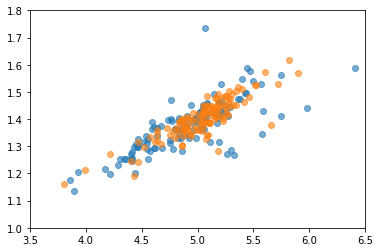

In [619]:
plt.scatter(x_chars_to_words[y == 0], x_syllables_to_words[y == 0, 0], alpha=0.6, label="Truthful")
plt.scatter(x_chars_to_words[y == 1], x_syllables_to_words[y == 1, 0], alpha=0.6, label="Fake")
plt.xlim(3.5, 6.5)
plt.ylim(1., 1.8)

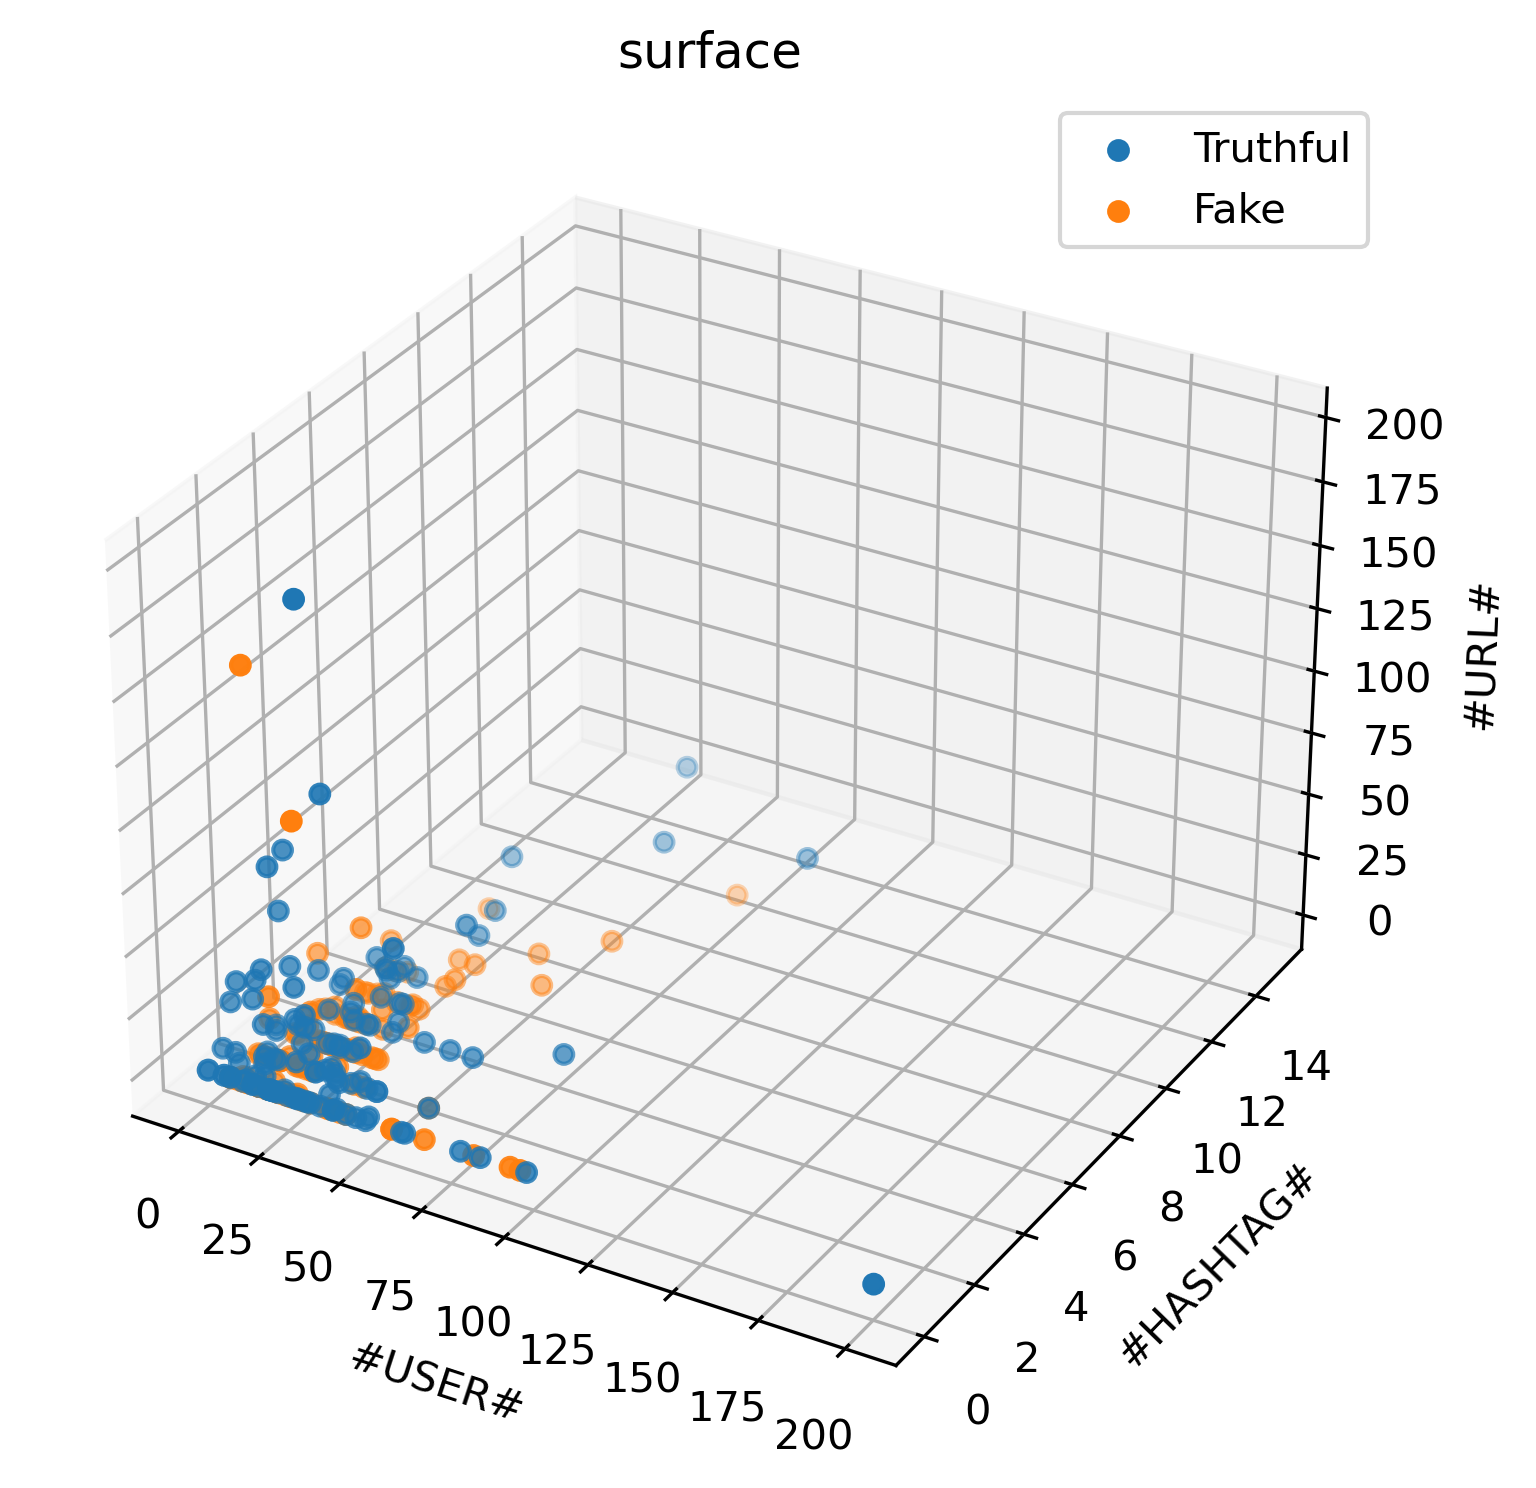

In [620]:
plt.figure(figsize=(8, 6), dpi=300)
ax = plt.axes(projection='3d')
ax.scatter3D(x_numbers[y == 0, 0], x_numbers[y == 0, 1], x_emoji_counts[y == 0], label="Truthful")
ax.scatter3D(x_numbers[y == 1, 0], x_numbers[y == 1, 1], x_emoji_counts[y == 1], label="Fake")
ax.set_xlabel(tags[0])
ax.set_ylabel(tags[1])
ax.set_zlabel(tags[2])
ax.set_title('surface');
ax.legend()